In [2]:
import os
os.chdir("/Users/ryan/Desktop/Fish Project")
import functions 
from functions import *
from glob import glob
import numpy as np
from hmmlearn import hmm
import pandas as pd
import matplotlib.pyplot as plt
test=os.listdir()
h5_files = sorted(glob('*.h5'))

## import data and extract certrain features

In [3]:
data_auto1_filt,data_auto2_filt = functions.getfiltereddata(h5_files)

fish1=data_auto1_filt

/Users/ryan/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:8767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/Users/ryan/Desktop/Fish Project/functions.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_auto2_filt['A_head']['x'] = data_auto2_filt['A_head']['x'] + 500
/Users/ryan/Desktop/Fish Project/functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

- periculum: the periculum
- angle:angle between 2 fish
- periculum_speed: the "derivative" of periculum obtained from set difference with the previous value, devided by 1/fps
- movement_speed: the fish's movement speed
- turning_angle: fish's turning angle, compared to it's orientation in a second before
- max periculum: describes fish's periculum's maximun from previous 40s to future 40s
- orietation: orietation defined by Yuqi \
all results have filled na with forward fill or back fill, the computation is incredibly time consuming is mainly because of the calculation of max_per, which I used a for loop to derive

In [4]:
periculum=functions.auto_scoring_get_opdeg(data_auto1_filt)
periculum=periculum.fillna(method="ffill")
angle=functions .gaze_tracking(data_auto1_filt,data_auto2_filt)
periculum_speed=periculum_speed(periculum)
movement_speed=speed(data_auto1_filt)
movement_speed=movement_speed.fillna(method="ffill")
turning_angle=turning_angle(data_auto1_filt)
turning_angle=pd.Series(turning_angle)
turning_angle=turning_angle.fillna(method="ffill")
max_per=find_local_max_per(periculum,width=40)
max_per=pd.Series(max_per)
ori=orientation2(data_auto1_filt)
ori=pd.Series(ori)
ori=ori.fillna(method="bfill")

Choose only the test period

In [5]:
periculum=periculum[87000:153800]
angle=angle[87000:153800]
periculum_speed=periculum_speed[87000:153800]
movement_speed=movement_speed[87000:153800]
turning_angle=turning_angle[87000:153800]
max_per=max_per[87000:153800]
ori=ori[87000:153800]

## bin the data
pivot each column of the data into 40 columns, so basically we are concerning only the features derived per second. pivot by 80 gave a sparcer data after doing pca, but the clustering result is similar.

In [6]:
df=pd.DataFrame(data=np.array([periculum,angle,periculum_speed,movement_speed,
                               turning_angle,max_per,ori,list(range(40))*1670,np.repeat(list(range(1670)),40)]).T)

In [7]:
df.columns=["periculum","angle","periculum_speed","movement_speed","turning_angle","max_per","ori","index","row"]

In [8]:
df_periculum=df[["periculum","index","row"]]
df_periculum=df_periculum.pivot(index="row",columns="index",values="periculum")
df_angle=df[["angle","index","row"]]
df_angle=df_angle.pivot(index="row",columns="index",values="angle")
df_periculum_speed=df[["periculum_speed","index","row"]]
df_periculum_speed=df_periculum_speed.pivot(index="row",columns="index",values="periculum_speed")
df_movement_speed=df[["movement_speed","index","row"]]
df_movement_speed=df_movement_speed.pivot(index="row",columns="index",values="movement_speed")
df_turning_angle=df[["turning_angle","index","row"]]
df_turning_angle=df_turning_angle.pivot(index="row",columns="index",values="turning_angle")
df_max_per=df[["max_per","index","row"]]
df_max_per=df_max_per.pivot(index="row",columns="index",values="max_per")
df_ori=df[["ori","index","row"]]
df_ori=df_ori.pivot(index="row",columns="index",values="ori")

In [9]:
from operator import add
df_periculum.columns=list(map(add,["periculum"]*40,list(map(str,range(40)))))
df_angle.columns=list(map(add,["angle"]*40,list(map(str,range(40)))))
df_periculum_speed.columns=list(map(add,["periculum_speed"]*40,list(map(str,range(40)))))
df_movement_speed.columns=list(map(add,["movement_speed"]*40,list(map(str,range(40)))))
df_turning_angle.columns=list(map(add,["turning_angle"]*40,list(map(str,range(40)))))
df_max_per.columns=list(map(add,["max_per"]*40,list(map(str,range(40)))))
df_ori.columns=list(map(add,["ori"]*40,list(map(str,range(40)))))

In [10]:
new_df=pd.concat([df_periculum,df_angle,df_periculum_speed,df_movement_speed,df_turning_angle,df_max_per,df_ori],
                axis=1,sort=False)

In [11]:
new_df=new_df.fillna(method="ffill")

## PCA

In [13]:
x=new_df.values
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(x)

In [14]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x)
pcs=pca.transform(x)

The scatter plot of the first 2 pcs.

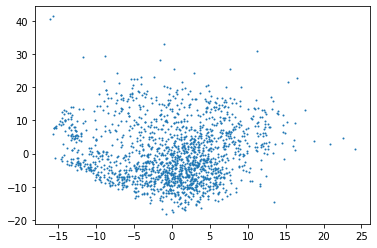

In [15]:
pcs=pcs[:,:2]
plt.scatter(pcs[:,1],pcs[:,0],s=1)

## Kmeans
We tried using 3,4,5 as num_clusters, from elbow method num_clusters=4 is the most reasonable choice, but we think the clustering result with 5 clusters makes more sense

In [18]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10)
kmeans.fit(pcs)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

The scatter plot after kmeans

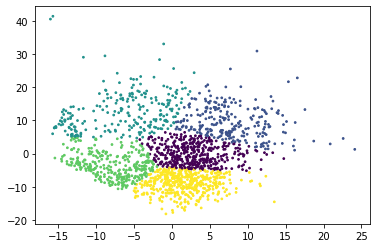

In [19]:
y=kmeans.predict(pcs)
plt.scatter(pcs[:, 1], pcs[:, 0], c=y,s=3, cmap='viridis')

In order to make the boundary less rigid and unnatural. I tried to give a contour to each cluster(actually a convex hull... it would be better looking if we rule out some outliers)\
Also, we can try using only 2 features and try to do a clustering, the points maybe more seperated? currently I have no idea.

In [20]:
from scipy.spatial import ConvexHull
pcs_0=pcs[y==0,:]
pcs_1=pcs[y==1,:]
pcs_2=pcs[y==2,:]
pcs_3=pcs[y==3,:]
pcs_4=pcs[y==4,:]
hull0=ConvexHull(pcs_0)
hull1=ConvexHull(pcs_1)
hull2=ConvexHull(pcs_2)
hull3=ConvexHull(pcs_3)
hull4=ConvexHull(pcs_4)

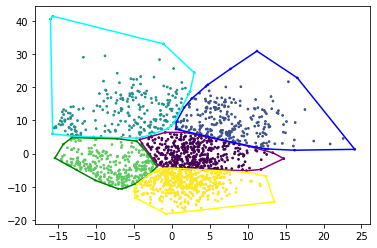

In [21]:
plt.scatter(pcs[:, 1], pcs[:, 0], c=y,s=3, cmap='viridis')
for simplex in hull0.simplices:
    plt.plot(pcs_0[simplex, 1], pcs_0[simplex, 0], 'k-',c="purple")
for simplex in hull1.simplices:
    plt.plot(pcs_1[simplex, 1], pcs_1[simplex, 0], 'k-',c="blue")
for simplex in hull2.simplices:
    plt.plot(pcs_2[simplex, 1], pcs_2[simplex, 0], 'k-',c="cyan")
for simplex in hull3.simplices:
    plt.plot(pcs_3[simplex, 1], pcs_3[simplex, 0], 'k-',c="green")   
for simplex in hull4.simplices:
    plt.plot(pcs_4[simplex, 1], pcs_4[simplex, 0], 'k-',c="yellow")   
plt.show()